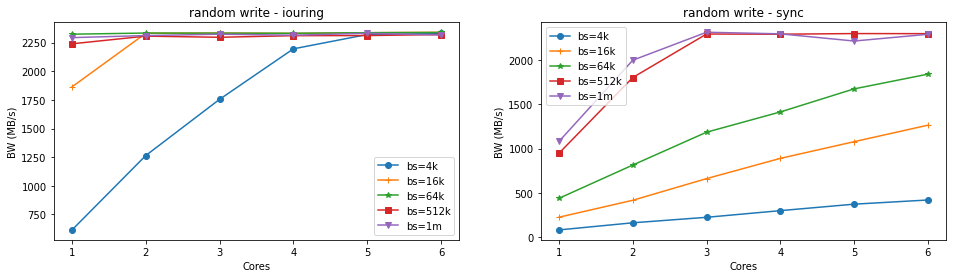

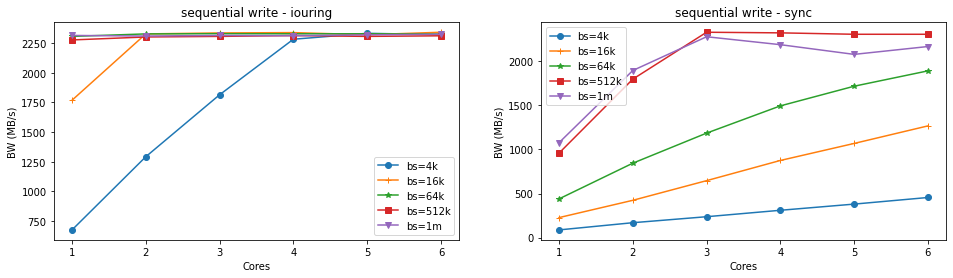

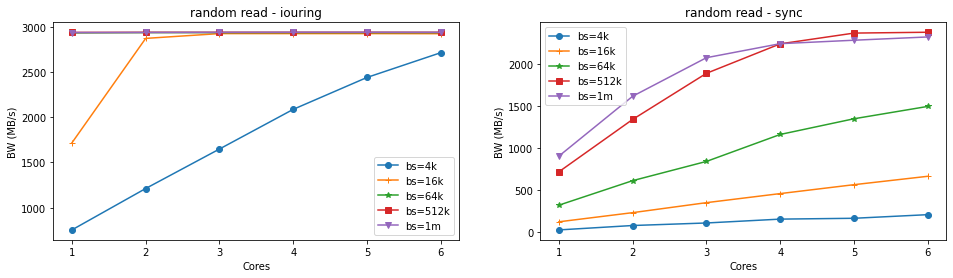

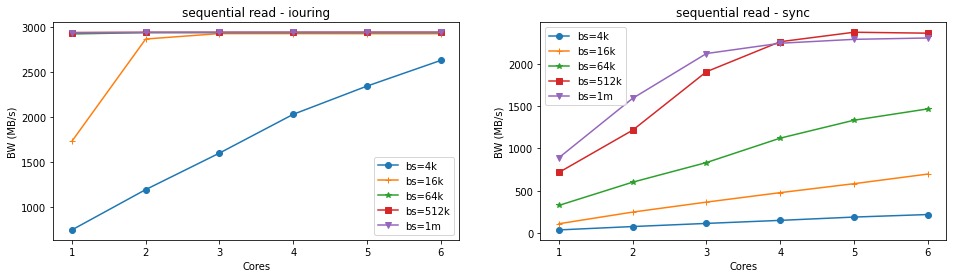

In [1]:
import sys
import matplotlib.pyplot as plt
import os
import re


temp = {
    'iouring': {
        1: {},
        2: {},
        3: {},
        4: {},
        5: {},
        6: {},
    },
    'sync': {
        1: {},
        2: {},
        3: {},
        4: {},
        5: {},
        6: {},
    },
}

thru_data_rand_write = thru_data_seq_write = thru_data_rand_read = \
thru_data_seq_read = thru_data_rand_rw = thru_data_seq_rw = temp


THR = 1
BS = 2
BW = 3
UNKNOWN = 4
state = 0

mode_iouring = 'iouring'
mode_sync = 'sync'

result_dir = 'results/fio'
bs_pattern = re.compile(r'^\[bs=([0-9]+[k|m]).*$')
thread_pattern = re.compile(r'^Starting (\d*).*$')
bw_pattern = re.compile(r'^\s+[write|read].+BW=.+MiB/s.*\(([0-9]+.[0-9]+)MB/s\).*$')


def get_path(fn):
    return os.path.join(result_dir, fn)


def parse_line(l):
    global state
    res = bs_pattern.match(l)
    if res is not None and len(res.groups()) == 1:
        state = BS
        return res.groups()[0] 
    res = thread_pattern.match(l)
    if res is not None and len(res.groups()) == 1:
        state = THR
        return res.groups()[0] 
    res = bw_pattern.match(l)
    if res is not None and len(res.groups()) == 1:
        state = BW
        return res.groups()[0] 
    return None


def _parse_log(t, log, mode):
    if t == 'randw':
        thru_data = thru_data_rand_write[mode]
    elif t == 'seqw':
        thru_data = thru_data_seq_write[mode]
    elif t == 'randr':
        thru_data = thru_data_rand_read[mode]
    elif t == 'seqr':
        thru_data = thru_data_seq_read[mode]
    elif t == 'randrw':
        thru_data = thru_data_randrw[mode]
    elif t == 'seqrw':
        thru_data = thru_data_seqrw[mode]
    
    global state
    with open(log) as f:
        current_threads = 0
        current_bs = ''
        lines = f.readlines()
        for line in lines:
            tok = parse_line(line)
            if tok is None:
                continue
            if state == BS:
                current_bs = tok
            elif state == THR:
                current_threads = int(tok)
            elif state == BW:
                thru_data[current_threads][current_bs] = float(tok)
    state = 0


def parse_rand_write_log():
    _parse_log('randw', get_path('rand_write_iouring.txt'), mode_iouring)
    _parse_log('randw', get_path('rand_write_sync.txt'), mode_sync)
    

def parse_seq_write_log():
    _parse_log('seqw', get_path('seq_write_iouring.txt'), mode_iouring)
    _parse_log('seqw', get_path('seq_write_sync.txt'), mode_sync)


def parse_rand_read_log():
    _parse_log('randr', get_path('rand_read_iouring.txt'), mode_iouring)
    _parse_log('randr', get_path('rand_read_sync.txt'), mode_sync)
    

def parse_seq_read_log():
    _parse_log('seqr', get_path('seq_read_iouring.txt'), mode_iouring)
    _parse_log('seqr', get_path('seq_read_sync.txt'), mode_sync)


def parse_rand_rw_log():
    _parse_log('randrw', get_path('rand_rw_iouring.txt'), mode_iouring)
    _parse_log('randrw', get_path('rand_rw_sync.txt'), mode_sync)
    
    
def parse_seq_rw_log():
    _parse_log('seqrw', get_path('seq_rw_iouring.txt'), mode_iouring)
    _parse_log('seqrw', get_path('seq_rw_sync.txt'), mode_sync)



def get_ys(d):
    ys = [None] * 5
    ys[0] = [d[i]['4k'] for i in range(1, 7)]
    ys[1] = [d[i]['16k'] for i in range(1, 7)]
    ys[2] = [d[i]['64k'] for i in range(1, 7)]
    ys[3] = [d[i]['512k'] for i in range(1, 7)]
    ys[4] = [d[i]['1m'] for i in range(1, 7)]
    return ys


def show_graph(d, title):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    x = [1, 2, 3, 4, 5, 6]
    ys = get_ys(d['iouring'])
    y_4k = ys[0]
    y_16k = ys[1]
    y_64k = ys[2]
    y_512k = ys[3]
    y_1m = ys[4]

    axes[0].xaxis.get_major_locator().set_params(integer=True)
    axes[0].plot(x, y_4k, marker='o', label='bs=4k')
    axes[0].plot(x, y_16k, marker='+', label='bs=16k')
    axes[0].plot(x, y_64k, marker='*', label='bs=64k')
    axes[0].plot(x, y_512k, marker='s', label='bs=512k')
    axes[0].plot(x, y_1m, marker='v', label='bs=1m')
    axes[0].set_title('%s - iouring' % title)
    axes[0].set_xlabel('Cores')
    axes[0].set_ylabel('BW (MB/s)')
    axes[0].legend()

    ys = get_ys(d['sync'])
    y_4k = ys[0]
    y_16k = ys[1]
    y_64k = ys[2]
    y_512k = ys[3]
    y_1m = ys[4]

    axes[1].xaxis.get_major_locator().set_params(integer=True)
    axes[1].plot(x, y_4k, marker='o', label='bs=4k')
    axes[1].plot(x, y_16k, marker='+', label='bs=16k')
    axes[1].plot(x, y_64k, marker='*', label='bs=64k')
    axes[1].plot(x, y_512k, marker='s', label='bs=512k')
    axes[1].plot(x, y_1m, marker='v', label='bs=1m')
    axes[1].set_title('%s - sync' % title)
    axes[1].set_xlabel('Cores')
    axes[1].set_ylabel('BW (MB/s)')
    axes[1].legend()

parse_rand_write_log()
show_graph(thru_data_rand_write, 'random write')

parse_seq_write_log()
show_graph(thru_data_seq_write, 'sequential write')

parse_rand_read_log()
show_graph(thru_data_rand_read, 'random read')

parse_seq_read_log()
show_graph(thru_data_seq_read, 'sequential read')
